In [38]:
suppressPackageStartupMessages({
  library(dplyr)
  library(pagoda2)
  library(cowplot)
  library(magrittr)
  library(dataorganizer)
  library(ggrastr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [5]:
### load up spatial data
spatial_seurat <- DatasetPath("human_pancreas", "so.rds") %>% readRDS()
spatial_annot <- DatasetPath("human_pancreas", "annotation.csv") %>% read.csv()
spatial_seurat@meta.data$cell_type <- spatial_annot$annotation
Idents(spatial_seurat) <- spatial_seurat@meta.data$cell_type

### load up spatial data
sc_data <- load_pancreas_sc_rna()
sc_seurat <- sc_data$sc_seurat
sc_annot <- sc_data$sc_annot
sc_obj <- sc_data$sc_obj

Normalizing layer: counts



In [3]:
# run DE
ct_annot <- sc_annot$annotation
names(ct_annot) <- rownames(sc_annot)
de_out_mark <- sc_data$sc_obj$getDifferentialGenes(
  verbose=TRUE, groups=ct_annot, z.threshold = 0,
  upregulated.only=TRUE, append.auc = TRUE
)

# put into a table
de_genes <- lapply(1:length(de_out_mark),function(i){
  ct_nm <- names(de_out_mark)[i]
  x <- de_out_mark[[i]]

  # add pvalues
  x$padj <- 2*pnorm(abs(x$Z), mean = 0, sd = 1, lower.tail = FALSE)

  x$cell_type <- ct_nm
  rownames(x) <- NULL
  return(x)
})

running differential expression with 6 clusters ... 

adjusting p-values ... 

done.




In [6]:
de_genes_full1 <- do.call("rbind.data.frame",de_genes)

# subset to same genes in spatial data
de_genes_full1 <- de_genes_full1[de_genes_full1$Gene %in% rownames(spatial_seurat),]

In [7]:
# subset to significant results only
de_genes_full1 <- de_genes_full1[de_genes_full1$padj<.05,]
# de_genes_full1 <- de_genes_full1[de_genes_full1$AUC>.6,]
de_genes_full1 <- de_genes_full1[de_genes_full1$AUC>.55,]
de_genes_full1 <- de_genes_full1[de_genes_full1$Specificity>.95,]
# de_genes_full1 <- de_genes_full1[abs(de_genes_full1$M)>log2(1.25),]

# order by AUC
de_genes_full1 <- de_genes_full1[order(de_genes_full1$AUC,decreasing = TRUE),]

ct_list <- lapply(unique(de_genes_full1$cell_type),function(ct){
  return(de_genes_full1[de_genes_full1$cell_type==ct,])
})
names(ct_list) <- unique(de_genes_full1$cell_type)

markers_plot <- unique(de_genes_full1$Gene)
all_expr_counts <- list()
for (ct in unique(Idents(sc_seurat))) {
  cells_keep <- rownames(sc_seurat@meta.data)[as.character(Idents(sc_seurat))==ct]
  sc_seurat_sub <- subset(sc_seurat,cells=cells_keep)
  expr <- sc_seurat_sub[['RNA']]$data[markers_plot,]
  cell_expr_counts <- rowSums(expr>0) / ncol(expr)
  all_expr_counts[[ct]] <- cell_expr_counts
}

all_expr_counts <- do.call(cbind,all_expr_counts)

for (ct in unique(de_genes_full1$cell_type)) {
  marker_df_sub <- de_genes_full1[de_genes_full1$cell_type==ct,]
  potential_markers <- marker_df_sub$Gene

  # now remove the markers if they are more highly expressed in other cell types
  g_rem_all <- c()
  for (mark in potential_markers) {
    de_sub_efrac <- all_expr_counts[mark,]
    de_sub_efrac2_other <- de_sub_efrac[names(de_sub_efrac)!=ct]
    if (de_sub_efrac[ct]<max(de_sub_efrac2_other)) {
      g_rem_all <- c(g_rem_all,mark)
    }

    if (sum(de_sub_efrac2_other>.6)>1) {
      g_rem_all <- c(g_rem_all,mark)
    }

  }
  ct_dat <- ct_list[[ct]]
  ct_dat <- ct_dat[!(ct_dat$Gene %in% g_rem_all),]
  ct_list[[ct]] <- ct_dat
}

# extract markers to plot
markers_plot <- lapply(levels(Idents(sc_seurat)),function(ct) {
  marker_df_sub <- ct_list[[ct]]
  if (length(marker_df_sub$Gene) > 5) {
    return(marker_df_sub$Gene[1:5])
  } else {
    return(marker_df_sub$Gene)
  }
})
markers_plot <- unique(unlist(markers_plot))
markers_plot <- rev(markers_plot)
markers_plot

[1] "AIF1"     "CD68"     "MS4A6A"   "PTPRC"    "CD14"     "HEPACAM2"
 [7] "GCG"      "INS"      "PCSK2"    "CHGA"     "SRPX"     "FBLN1"   
[13] "COL5A2"   "CRISPLD2" "C7"       "TMC5"     "PPP1R1B"  "EHF"     
[19] "PROX1"    "CLEC14A"  "RAMP2"    "ERG"      "EGFL7"    "VWF"     
[25] "SLC26A3"  "GATM"     "DPEP1"    "ANPEP"    "AQP8"

In [8]:
# save the full table of thresholded markers
ct_list_df <- do.call(rbind.data.frame,ct_list)
write.csv(ct_list_df, DatasetPath("human_pancreas", "pancreas_markers_sub.csv"))

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


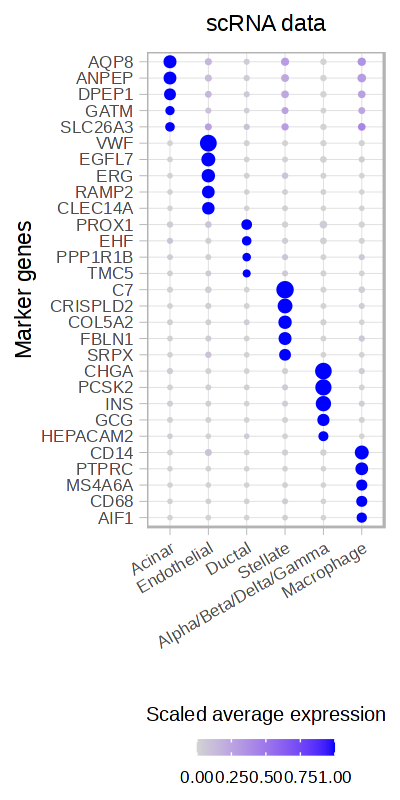

In [9]:
options(repr.plot.width = 2, repr.plot.height = 4, repr.plot.res = 200)

p <- DotPlot(object = sc_seurat, features = markers_plot,
             col.min = 0,col.max = 5)

p$data$avg.exp.scaled <- NA
p_dat_lst <- lapply(markers_plot,function(g) {
  p_dat_sub <- p$data[p$data$features.plot==g,]
  X <- p_dat_sub$avg.exp
  min_val <- min(X)
  max_val <- max(X)
  X_std = (X - min_val) / (max_val - min_val)
  p_dat_sub$avg.exp.scaled <- X_std
  return(p_dat_sub)
})

p_dat_lst2 <- do.call(rbind.data.frame,p_dat_lst)

p$data <- p_dat_lst2

p$layers[[1]] <- NULL

p_sc <- p +
  geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp.scaled')) + # change to avg.exp.log or avg.exp.log.scaled or avg.exp.scaled
  coord_flip() +
  xlab('Marker genes') +
  ylab('') +
  ggtitle('scRNA data') +
  theme_light(base_line_size = gg_line_thickness) +
  scale_radius(range = c(0,2)) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
        legend.key.size = unit(6, 'pt'),
        legend.key.height = unit(6, 'pt'),
        legend.key.width = unit(10, 'pt'),
        legend.title=element_text(size=7),
        legend.text=element_text(size=6),
        legend.position="bottom",
        legend.box="vertical", legend.margin=margin()) +
  guides(colour = guide_colourbar(title.position="top", title.hjust = 0.5),
         size = 'none') +
  labs(colour="Scaled average expression")

p_sc



Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


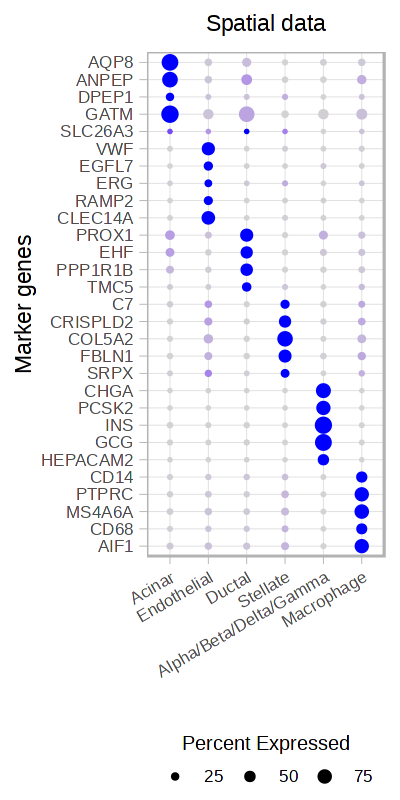

In [ ]:
cells_keep <- rownames(spatial_seurat@meta.data)[spatial_seurat@meta.data$cell_type %in% levels(Idents(sc_seurat))]
spatial_seurat_sub <- subset(spatial_seurat,cells=cells_keep)
Idents(spatial_seurat_sub) <- factor(spatial_seurat_sub@meta.data$cell_type,levels=levels(Idents(sc_seurat)))

p <- DotPlot(object = spatial_seurat_sub, features = markers_plot,
             col.min = 0,col.max = 5)

  # changing some column names
  colnames(tx_dat)[colnames(tx_dat)=='x_location'] <- 'x'
  colnames(tx_dat)[colnames(tx_dat)=='y_location'] <- 'y'
  colnames(tx_dat)[colnames(tx_dat)=='z_location'] <- 'z'
  colnames(tx_dat)[colnames(tx_dat)=='cell_id'] <- 'cell'
  colnames(tx_dat)[colnames(tx_dat)=='feature_name'] <- 'gene'

p$data$avg.exp.scaled <- NA
p_dat_lst <- lapply(markers_plot,function(g) {
  p_dat_sub <- p$data[p$data$features.plot==g,]
  X <- p_dat_sub$avg.exp
  min_val <- min(X)
  max_val <- max(X)
  X_std = (X - min_val) / (max_val - min_val)
  p_dat_sub$avg.exp.scaled <- X_std
  return(p_dat_sub)
})

p_dat_lst2 <- do.call(rbind.data.frame,p_dat_lst)

p$data <- p_dat_lst2

p$layers[[1]] <- NULL

p_spat <- p +
  geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp.scaled')) +
  coord_flip() +
  xlab('Marker genes') +
  ylab('') +
  ggtitle('Spatial data') +
  theme_light(base_line_size = gg_line_thickness) +
  scale_radius(range = c(0,2)) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
        legend.key.size = unit(6, 'pt'),
        legend.key.height = unit(6, 'pt'),
        legend.key.width = unit(10, 'pt'),
        legend.title=element_text(size=7),
        legend.text=element_text(size=6),
        legend.position="bottom",
        legend.box="vertical", legend.margin=margin()) +
  guides(colour = 'none',
         size = guide_legend(title.position="top", title.hjust = 0.5)) +
  labs(size="Percent Expressed")

p_spat



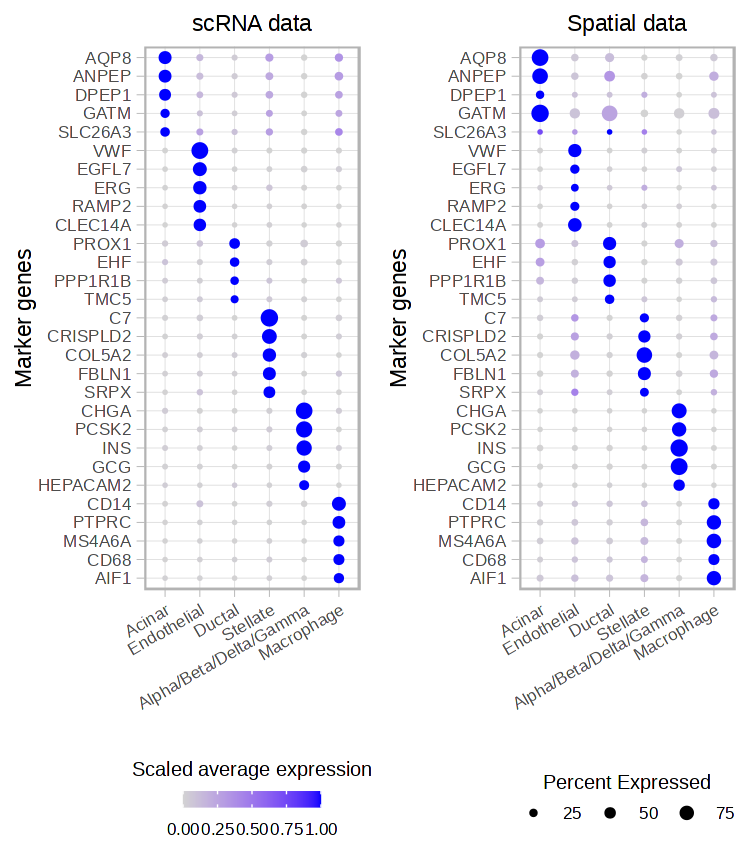

In [13]:
options(repr.plot.width = 3.75, repr.plot.height =4.25, repr.plot.res = 200)

fig <- plot_grid(p_sc,p_spat,nrow=1,rel_widths = c(.5,.5),align = 'hv')
fig

In [14]:
pdf(OutputPath("pancreas_sc_spatial_marker_dotplots.pdf"), useDingbats=FALSE,width=3.75, height=4.25)
fig
dev.off()

png 
  2

In [16]:
######## now making a prevalence plot
all_markers <- DatasetPath("human_pancreas", "pancreas_markers_sub.csv") %>% read.csv()

admix_markers = all_markers$Gene[all_markers$cell_type=='Stellate']

all_markers_list <- lapply(unique(all_markers$cell_type),function(x){
  return(all_markers$Gene[all_markers$cell_type==x])
})
names(all_markers_list) <- unique(all_markers$cell_type)


seurat_spatial_counts <- spatial_seurat_sub[['RNA']]$counts
seurat_sc_counts <- sc_seurat[['RNA']]$counts

lib_sizes_spat2 <- colSums(seurat_spatial_counts)
lib_sizes_sc2 <- colSums(seurat_sc_counts)
fracs_spat <- colSums(seurat_spatial_counts[admix_markers,]) / lib_sizes_spat2
fracs_sc <- colSums(seurat_sc_counts[admix_markers,]) / lib_sizes_sc2

admix_cat <- list(c(0.05,0.1),c(0.1,.2),c(.2,1))
tmp <- list()
spat_ct <- as.character(Idents(spatial_seurat_sub))
sc_ct <- as.character(Idents(sc_seurat))
for (i in 1:length(admix_cat)) {
  admix_range <- admix_cat[[i]]
  for (ct in unique(spat_ct)) {
    ndx_keep <- which(spat_ct==ct)
    fracs_spat_sub <- fracs_spat[ndx_keep]
    count_in_range <- sum(fracs_spat_sub>admix_range[1] & fracs_spat_sub<admix_range[2])
    frac_in_range <- count_in_range / length(fracs_spat_sub)
    tmp[[length(tmp)+1]] <- c(frac_in_range,ct,'ST',paste0(admix_range[1],'-',admix_range[2]))

    ndx_keep <- which(sc_ct==ct)
    fracs_sc_sub <- fracs_sc[ndx_keep]
    count_in_range <- sum(fracs_sc_sub>admix_range[1] & fracs_sc_sub<admix_range[2])
    frac_in_range <- count_in_range / length(fracs_sc_sub)
    tmp[[length(tmp)+1]] <- c(frac_in_range,ct,'scRNA',paste0(admix_range[1],'-',admix_range[2]))
  }
}

tmp <- do.call(rbind.data.frame,tmp)
colnames(tmp) <- c('frac','cell_type','assay','admix_cat')
tmp$frac <- as.numeric(tmp$frac)

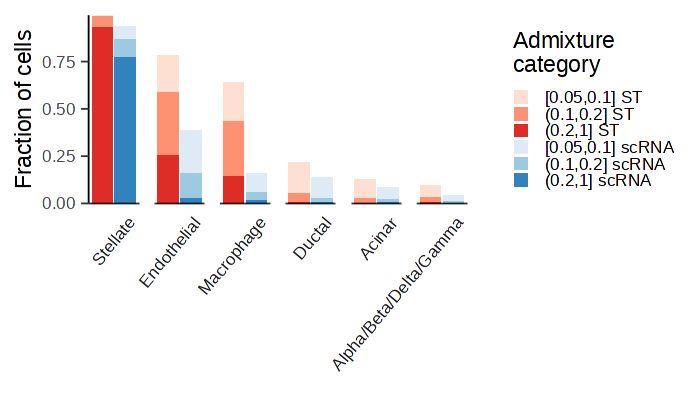

In [35]:
options(repr.plot.width = 3.5, repr.plot.height = 2, repr.plot.res = 200)

tmp$admix_cat2 <- paste0(tmp$admix_cat,' ',tmp$assay)
tmp$admix_cat2 <- factor(tmp$admix_cat2,levels=c('0.05-0.1 ST','0.1-0.2 ST','0.2-1 ST','0.05-0.1 scRNA','0.1-0.2 scRNA','0.2-1 scRNA'))
levels(tmp$admix_cat2) <- c('[0.05,0.1] ST','(0.1,0.2] ST','(0.2,1] ST','[0.05,0.1] scRNA','(0.1,0.2] scRNA','(0.2,1] scRNA')
tmp$assay <- factor(tmp$assay,levels=c('ST','scRNA'))

myColors <- c(RColorBrewer::brewer.pal(3,'Reds'),RColorBrewer::brewer.pal(3,'Blues'))

tmp$cell_type <- factor(tmp$cell_type,levels=c("Stellate","Endothelial","Macrophage","Ductal","Acinar","Alpha/Beta/Delta/Gamma"))
p <- tmp %>%
  ggplot(aes(x=assay, y=frac, fill=admix_cat2)) +
  geom_col() +
  ylab('Fraction of cells') +
  theme_classic(base_line_size = gg_line_thickness) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.line.x = element_blank()) +
  geom_hline(yintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  scale_fill_manual(breaks = c('[0.05,0.1] ST','(0.1,0.2] ST','(0.2,1] ST','[0.05,0.1] scRNA','(0.1,0.2] scRNA','(0.2,1] scRNA'), values = myColors) +
  scale_y_continuous(expand = expansion(0)) +
  scale_x_discrete(drop = FALSE) +
  facet_wrap(~cell_type, scales = 'free_x', nrow = 1,strip.position = 'bottom') +
  labs(fill='Admixture\ncategory') +
  p_theme +
  theme(strip.text.x = element_text(angle = 50, size=6, vjust=1, hjust=1),
        strip.background = element_blank(),
        strip.clip = "off",
        legend.text=element_text(size=6),
        legend.key.size = unit(6, 'pt'),
        legend.key.height = unit(6, 'pt'),
        legend.key.width = unit(6, 'pt')
  )

p


In [36]:
pdf(OutputPath("pancreas_prevalence.pdf"), useDingbats=FALSE,
    width = 3.5, height = 2.25)
p
dev.off()

png 
  2

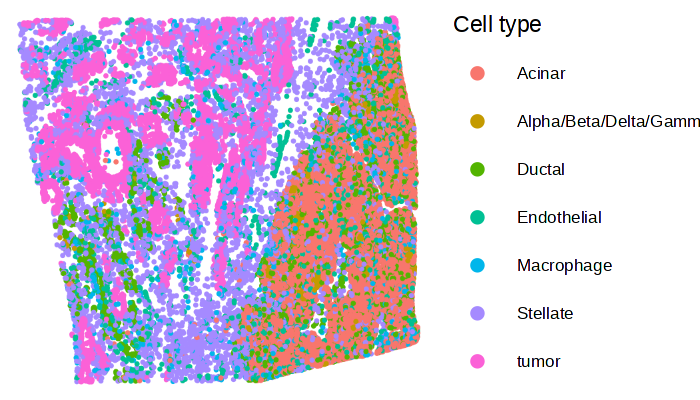

In [39]:
#### plotting the slide and cell type composition stats
Idents(spatial_seurat) <- spatial_seurat@meta.data$cell_type

p <- ggplot(spatial_seurat@meta.data,aes(x=x_centroid,y=y_centroid,color=cell_type)) +
  geom_point_rast(size=.001)

p <- p +
  labs(color='Cell type') +
  theme_void() +
  legend_mod +
  theme(text = element_text(family = font_choice),
        legend.text=element_text(size=6),
        legend.title=element_text(size=8))
p

In [40]:
# getting height width ratio to keep aspect ratio accurate in the pdf
x_diff <- max(spatial_seurat$x_centroid) - min(spatial_seurat$x_centroid)
y_diff <- max(spatial_seurat$y_centroid) - min(spatial_seurat$y_centroid)
aspect_ratio <- y_diff / x_diff

width_plot <- 3
height_plot <- aspect_ratio * width_plot
print(height_plot)

[1] 1.220798


In [41]:
pdf(OutputPath("pancreas_slide_ct.pdf"), useDingbats = FALSE,
    width = width_plot, height = height_plot)
p + theme(legend.position="none")
dev.off()

png 
  2

In [42]:
pdf(OutputPath("pancreas_slide_ct_legend.pdf"), useDingbats = FALSE,
    width = width_plot+.5, height = height_plot)
p
dev.off()

png 
  2